### Import Libraries and Initial Setup

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Set global display options for Pandas
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 400)

print("Libraries imported and configurations set.")


Libraries imported and configurations set.


### Load Data

In [2]:
# Load Data
def load_data(path, sheet_name):
    """Load the Excel file and return a DataFrame."""
    return pd.read_excel(path, sheet_name=sheet_name)

path_to_excel = "../data/EVS4_20140118_dataV9.xlsx"
df = load_data(path_to_excel, sheet_name="DatasetV9")
print("Data loaded successfully.")
df.head()

Data loaded successfully.


,BNR_NNR,cTOTEXn,cTOTEXs,cTOTEXs_RP3,cTOTEXn_RP3,BNR,dmu,dDateData,dmuName,yConnections.N1,yConnections.N2,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N1,yConnections.cus.N2,yConnections.cus.N3,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N1,yInjectionPoints.N2,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N1,yInjectionPoints.renewables.N2,yInjectionPoints.renewables.N3,yInjectionPoints.renewables.N4,yInjectionPoints.renewables.N5,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N1,yInjectionPoints.renewables.solar.N2,yInjectionPoints.renewables.solar.N3,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N5,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N1,yInjectionPoints.renewables.wind.N2,yInjectionPoints.renewables.wind.N3,yInjectionPoints.renewables.wind.N4,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N6,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N1,yInjectionPoints.renewables.biomass.N2,yInjectionPoints.renewables.biomass.N3,yInjectionPoints.renewables.biomass.N4,yInjectionPoints.renewables.biomass.N5,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N1,yInjectionPoints.renewables.hydro.N2,yInjectionPoints.renewables.hydro.N3,yInjectionPoints.renewables.hydro.N4,yInjectionPoints.renewables.hydro.N5,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N1,yInjectionPoints.KWKG.N2,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N1,yInjectionPoints.other.N2,yInjectionPoints.other.N3,yInjectionPoints.other.N4,yInjectionPoints.other.N5,yInjectionPoints.other.N6,yInjectionPoints.other.N7,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N1,yConnections.incl.inj.N2,yConnections.incl.inj.N3,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N1,yMeters.read.op.N2,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N5,yMeters.read.op.N6,yMeters.read.op.N7,yMeters.unoccupied.N1,yMeters.unoccupied.N2,yMeters.unoccupied.N3,yMeters.unoccupied.N4,yMeters.unoccupied.N5,yMeters.unoccupied.N6,yMeters.unoccupied.N7,yMeters.read.ext.N1,yMeters.read.ext.N2,yMeters.read.ext.N3,yMeters.read.ext.N4,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.ext.N7,yMeters.read.N1,yMeters.read.N2,yMeters.read.N3,yMeters.read.N4,yMeters.read.N5,yMeters.read.N6,yMeters.read.N7,yMeters.flatrate.N1,yMeters.flatrate.N2,yMeters.flatrate.N3,yMeters.flatrate.N4,yMeters.flatrate.N5,yMeters.flatrate.N6,yMeters.flatrate.N7,yMeters.active.N1,yMeters.active.N2,yMeters.active.N3,yMeters.active.N4,yMeters.active.N5,yMeters.active.N6,yMeters.active.N7,yMeters.all.N1,yMeters.all.N2,yMeters.all.N3,yMeters.all.N4,yMeters.all.N5,yMeters.all.N6,yMeters.all.N7,yMeters.cp.ctrl.N1,yMeters.cp.ctrl.N2,yMeters.cp.ctrl.N3,yMeters.cp.ctrl.N4,yMeters.cp.ctrl.N5,yMeters.cp.ctrl.N6,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N1,yMeters.cp.nonctrl.N2,yMeters.cp.nonctrl.N3,yMeters.cp.nonctrl.N4,yMeters.cp.non

### Identify Columns with the Most Missing Values

In [3]:
# Identify Columns with the Most Missing Values
missing_values = df.isnull().sum()
missing_values_sorted = missing_values.sort_values(ascending=False)
print("Columns with the most missing values:")
display(missing_values_sorted.head(20))

# Drop columns with more than 30% missing values and irrelevant columns
columns_to_drop = ['yRelativeLowerPower.scaled.corr.N4', 'yRelativeLowerPower.N4', 'yRelativeLowerPower.scaled.N4', 
                   'cTOTEXs', 'cTOTEXs_RP3', 'cTOTEXn_RP3', 'NameOrg', 'NameShort', 'dmuName', 'dmu', 'dDateData', 'BNR', 'BNR_NNR']
df_cleaned = df.drop(columns=columns_to_drop)
print("Number of columns to drop:", len(columns_to_drop))
df_cleaned.head()


Columns with the most missing values:


yRelativeLowerPower.scaled.corr.N4                    67
yRelativeLowerPower.N4                                67
yRelativeLowerPower.scaled.N4                         67
rUsageHours.delivered.N4                              20
rUsageHours.injection.N4                              20
rMeters.read.per.connection.cus.N3                    14
rMeters.read.per.connection.cus.N4                    11
cTOTEXn_RP3                                            9
cTOTEXs_RP3                                            9
rUsageHours.delivered.N2                               7
rUsageHours.injection.N2                               7
rInstalledPower.per.peakinj.N4                         4
rMeters.read.per.connection.cus.N6                     4
rInstalledPower.renewables.per.point.renewables.N4     3
rInstalledPower.renewables.solar.per.point.N3          3
rInstalledPower.renewables.solar.per.point.N4          3
rInstalledPower.per.peakinj.N2                         3
rInstalledPower.renewables.wind

Number of columns to drop: 13


,cTOTEXn,yConnections.N1,yConnections.N2,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N1,yConnections.cus.N2,yConnections.cus.N3,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N1,yInjectionPoints.N2,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N1,yInjectionPoints.renewables.N2,yInjectionPoints.renewables.N3,yInjectionPoints.renewables.N4,yInjectionPoints.renewables.N5,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N1,yInjectionPoints.renewables.solar.N2,yInjectionPoints.renewables.solar.N3,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N5,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N1,yInjectionPoints.renewables.wind.N2,yInjectionPoints.renewables.wind.N3,yInjectionPoints.renewables.wind.N4,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N6,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N1,yInjectionPoints.renewables.biomass.N2,yInjectionPoints.renewables.biomass.N3,yInjectionPoints.renewables.biomass.N4,yInjectionPoints.renewables.biomass.N5,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N1,yInjectionPoints.renewables.hydro.N2,yInjectionPoints.renewables.hydro.N3,yInjectionPoints.renewables.hydro.N4,yInjectionPoints.renewables.hydro.N5,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N1,yInjectionPoints.KWKG.N2,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N1,yInjectionPoints.other.N2,yInjectionPoints.other.N3,yInjectionPoints.other.N4,yInjectionPoints.other.N5,yInjectionPoints.other.N6,yInjectionPoints.other.N7,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N1,yConnections.incl.inj.N2,yConnections.incl.inj.N3,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N1,yMeters.read.op.N2,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N5,yMeters.read.op.N6,yMeters.read.op.N7,yMeters.unoccupied.N1,yMeters.unoccupied.N2,yMeters.unoccupied.N3,yMeters.unoccupied.N4,yMeters.unoccupied.N5,yMeters.unoccupied.N6,yMeters.unoccupied.N7,yMeters.read.ext.N1,yMeters.read.ext.N2,yMeters.read.ext.N3,yMeters.read.ext.N4,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.ext.N7,yMeters.read.N1,yMeters.read.N2,yMeters.read.N3,yMeters.read.N4,yMeters.read.N5,yMeters.read.N6,yMeters.read.N7,yMeters.flatrate.N1,yMeters.flatrate.N2,yMeters.flatrate.N3,yMeters.flatrate.N4,yMeters.flatrate.N5,yMeters.flatrate.N6,yMeters.flatrate.N7,yMeters.active.N1,yMeters.active.N2,yMeters.active.N3,yMeters.active.N4,yMeters.active.N5,yMeters.active.N6,yMeters.active.N7,yMeters.all.N1,yMeters.all.N2,yMeters.all.N3,yMeters.all.N4,yMeters.all.N5,yMeters.all.N6,yMeters.all.N7,yMeters.cp.ctrl.N1,yMeters.cp.ctrl.N2,yMeters.cp.ctrl.N3,yMeters.cp.ctrl.N4,yMeters.cp.ctrl.N5,yMeters.cp.ctrl.N6,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N1,yMeters.cp.nonctrl.N2,yMeters.cp.nonctrl.N3,yMeters.cp.nonctrl.N4,yMeters.cp.nonctrl.N5,yMeters.cp.nonctrl.N6,yMeters.cp.nonctrl.N7,yMeters.house.

These are the 20/904 variables with the most missing values. Considering the low number of observations (194), we will drop `yRelativeLowerPower.scaled.corr.N4`, `yRelativeLowerPower.N4`, and `yRelativeLowerPower.scaled.N4`, which have more than 30% of their values missing.  
We also drop irrelevant columns for the prediction, such as name, date of data collection, and the TOTEX-variables besides `cTOTEXn`.

### Handle Sparse Variables

In [4]:
# Drop columns with more than 90% zero values
threshold = 0.9 * len(df_cleaned)
sparse_columns_to_drop = [col for col in df_cleaned.columns if (df_cleaned[col] == 0).sum() > threshold]
df_cleaned = df_cleaned.drop(columns=sparse_columns_to_drop)
print("Number of sparse columns to drop:", len(sparse_columns_to_drop))
df_cleaned.head()


Number of sparse columns to drop: 314


,cTOTEXn,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N3,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N3,yInjectionPoints.renewables.N4,yInjectionPoints.renewables.N5,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N5,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N4,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N5,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N5,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N3,yInjectionPoints.other.N4,yInjectionPoints.other.N5,yInjectionPoints.other.N6,yInjectionPoints.other.N7,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N3,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N5,yMeters.read.op.N6,yMeters.read.op.N7,yMeters.unoccupied.N5,yMeters.unoccupied.N7,yMeters.read.ext.N3,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.ext.N7,yMeters.read.N3,yMeters.read.N4,yMeters.read.N5,yMeters.read.N6,yMeters.read.N7,yMeters.flatrate.N7,yMeters.active.N3,yMeters.active.N4,yMeters.active.N5,yMeters.active.N6,yMeters.active.N7,yMeters.all.N3,yMeters.all.N4,yMeters.all.N5,yMeters.all.N6,yMeters.all.N7,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N5,yMeters.cp.nonctrl.N7,yMeters.house.N5,yMeters.house.N6,yMeters.house.N7,yMeters.over10MWh.noRPM.N5,yMeters.over10MWh.noRPM.N6,yMeters.over10MWh.noRPM.N7,yMeters.over10MWh.RPM.N3,yMeters.over10MWh.RPM.N4,yMeters.over10MWh.RPM.N5,yMeters.over10MWh.RPM.N6,yMeters.over10MWh.RPM.N7,yMeters.others.N3,yMeters.others.N4,yMeters.others.N5,yMeters.others.N6,yMeters.others.N7,yMeters.cp.ctrl.tot,yMeters.cp.nonctrl.tot,yMeters.cp.tot,yMeters.read.tot,yMeters.read.noncp.sum,yMeters.active.tot,yMeters.all.tot,yMeters.house.tot,yMeters.over10MWh.noRPM.tot,yMeters.over10MWh.RPM.tot,yMeters.others.tot,yMeters.noncp.ctrl.tot,yMeters.noncp.ctrl.excl.house.tot,yCables.circuit.N3,yCables.circuit.N5,yCables.circuit.N7,yCables.house.N7,yCables.streetlights.N7,yCables.all.N7,yCables.excl.house.N7,yCables.all.N13.sum,yCables.circuit.tot,yCables.all.tot,yCables.all.N57.sum,yLines.circuit.N3,yLines.circuit.N5,yLines.circuit.N7,yLines.house.N7,yLines.all.N7,yLines.excl.house.N7,yLines.all.N13.sum,yLines.circuit.tot,yLines.all.tot,yLines.all.N57.sum,yNet.length.N3,yNet.length.N5,yNet.length.circuit.N7,yNet.length.N7,yNet.length.excl.house.N7,yNet.length.circuit.tot,yNet.length.all.tot,yNet.length.excl.house.tot,ySubstations.N4,ySubstations.N5,ySubstations.N6,ySubstations.N7,ySubstations.own.N4,ySubstations.own.N5,ySubstations.own.N6,ySubstations.own.N7,ySubstations.own.tot,yTransformers.N5,yTransformers.N6,yTransformers.N7,yTransformers.ront.N4,yTransformers.ront.N5,yTransformers.ront.N6,yTransformers.reserve.N6,yTransformers.ront.reserve.N4,yTransformers.tot,yTransformers

There are many extremely sparse variables, with mostly 0 values. We set a rather lax condition for removing these (>90% missing values), as we will be using models that work well with sparse features such as Random Forest or Lasso Regression and otherwise use feature selection methods.


### Confirm No Categorical Variables

In [5]:
# Check for Categorical Variables
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
print("Categorical columns:", list(categorical_columns))


Categorical columns: []


There are no categorical variables to one-hot-encode.


### Outlier Detection Strategy

In [6]:
# Outlier Detection
def detect_high_value_outliers(df, z_thresh=3):
    """Detect outliers in the value range larger than the mean of each column."""
    outlier_indices = set()
    outlier_columns = []

    for col in df.columns:
        thresh_value = df[col].mean()
        high_values = df[df[col] > thresh_value][col]
        high_value_z_scores = np.abs(stats.zscore(high_values.dropna()))
        high_value_outliers = high_values[high_value_z_scores > z_thresh]
        
        if not high_value_outliers.empty:
            outlier_indices.update(high_value_outliers.index.tolist())
            outlier_columns.append(col)
    
    outlier_indices = list(outlier_indices)
    outlier_df = df.loc[outlier_indices, outlier_columns]
    return outlier_df

train_outliers = detect_high_value_outliers(df_cleaned, z_thresh=3)
print("Training set outliers:")
display(train_outliers)


Training set outliers:


,cTOTEXn,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N4,yInjectionPoints.other.N6,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N7,yMeters.unoccupied.N5,yMeters.unoccupied.N7,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.N3,yMeters.read.N4,yMeters.read.N7,yMeters.flatrate.N7,yMeters.active.N3,yMeters.active.N4,yMeters.active.N7,yMeters.all.N3,yMeters.all.N4,yMeters.all.N7,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N7,yMeters.house.N7,yMeters.over10MWh.noRPM.N5,yMeters.over10MWh.noRPM.N7,yMeters.over10MWh.RPM.N3,yMeters.over10MWh.RPM.N4,yMeters.over10MWh.RPM.N5,yMeters.over10MWh.RPM.N6,yMeters.over10MWh.RPM.N7,yMeters.others.N3,yMeters.others.N4,yMeters.others.N5,yMeters.others.N7,yMeters.cp.ctrl.tot,yMeters.cp.nonctrl.tot,yMeters.cp.tot,yMeters.read.tot,yMeters.read.noncp.sum,yMeters.active.tot,yMeters.all.tot,yMeters.house.tot,yMeters.over10MWh.noRPM.tot,yMeters.over10MWh.RPM.tot,yMeters.others.tot,yMeters.noncp.ctrl.tot,yMeters.noncp.ctrl.excl.house.tot,yCables.circuit.N3,yCables.circuit.N5,yCables.circuit.N7,yCables.house.N7,yCables.streetlights.N7,yCables.all.N7,yCables.excl.house.N7,yCables.all.N13.sum,yCables.circuit.tot,yCables.all.tot,yCables.all.N57.sum,yLines.circuit.N5,yLines.house.N7,yNet.length.N5,yNet.length.circuit.N7,yNet.length.N7,yNet.length.excl.house.N7,yNet.length.circuit.tot,yNet.length.all.tot,yNet.length.excl.house.tot,ySubstations.N4,ySubstations.N5,ySubstations.N6,ySubstations.N7,ySubstations.own.N4,ySubstations.own.N5,ySubstations.own.N6,ySubstations.own.N7,ySubstations.own.tot,yTransformers.N5,yTransformers.N6,yTransformers.N7,yTransformers.ront.N4,yTransformers.ront.N5,yTransformers.tot,yTransformers.power.N6,yTransformers.power.N7,yTransformers.power.own.N6,yTransformers.power.own.N7,yTransformers.power.ront.N4,yTransformers.power.ront.N5,yTransformers.power.ront.own.N4,yTransformers.power.ront.own.N5,ySwitchingstations.N3,ySwitchingstations.N5,ySwitchingstations.N7,yInstalledPower.N6,yInstalledPower.N7,yInstalledPower.renewables.N6,yInstalledPower.renewables.N7,yInstalledPower.renewables.solar.N6,yInstalledPower.renewables.solar.N7,yInstalledPower.renewables.wind.N5,yInstalledPower.renewables.wind.N7,yInstalledPower.renewables.biomass.N6,yInstalledPower.renewables.biomass.N7,yInstalledPower.renewables.hydro.N5,yInstalledPower.renewables.hydro.N6,yInstalledPower.renewables.hydro.N7,yInstalledPower.KWKG.N3,yInstalledPower.KWKG.N4,yInstalledPower.KWKG.N5,yInstalledPower.KWKG.N6,yInstalledPower.other.N4,yInstalledPower.other.N5,yInstalledPower.other.N6,yInstalle

There are many variables that have both many 0 values and many very large values due to very different network structures for each of the providers. Therefore, a simple z-score approach on the full dataset faces issues with identifying outliers as the 0s skew the distribution heavily. Instead, we look only at data points larger than the mean and use the z-score threshold of 3 on this subset to identify outliers.


### Summary of Outliers

In [7]:
# Summary of Outliers
outlier_summary = train_outliers.describe()
print("Outlier summary:")
display(outlier_summary)


Outlier summary:


,cTOTEXn,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N4,yInjectionPoints.other.N6,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N7,yMeters.unoccupied.N5,yMeters.unoccupied.N7,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.N3,yMeters.read.N4,yMeters.read.N7,yMeters.flatrate.N7,yMeters.active.N3,yMeters.active.N4,yMeters.active.N7,yMeters.all.N3,yMeters.all.N4,yMeters.all.N7,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N7,yMeters.house.N7,yMeters.over10MWh.noRPM.N5,yMeters.over10MWh.noRPM.N7,yMeters.over10MWh.RPM.N3,yMeters.over10MWh.RPM.N4,yMeters.over10MWh.RPM.N5,yMeters.over10MWh.RPM.N6,yMeters.over10MWh.RPM.N7,yMeters.others.N3,yMeters.others.N4,yMeters.others.N5,yMeters.others.N7,yMeters.cp.ctrl.tot,yMeters.cp.nonctrl.tot,yMeters.cp.tot,yMeters.read.tot,yMeters.read.noncp.sum,yMeters.active.tot,yMeters.all.tot,yMeters.house.tot,yMeters.over10MWh.noRPM.tot,yMeters.over10MWh.RPM.tot,yMeters.others.tot,yMeters.noncp.ctrl.tot,yMeters.noncp.ctrl.excl.house.tot,yCables.circuit.N3,yCables.circuit.N5,yCables.circuit.N7,yCables.house.N7,yCables.streetlights.N7,yCables.all.N7,yCables.excl.house.N7,yCables.all.N13.sum,yCables.circuit.tot,yCables.all.tot,yCables.all.N57.sum,yLines.circuit.N5,yLines.house.N7,yNet.length.N5,yNet.length.circuit.N7,yNet.length.N7,yNet.length.excl.house.N7,yNet.length.circuit.tot,yNet.length.all.tot,yNet.length.excl.house.tot,ySubstations.N4,ySubstations.N5,ySubstations.N6,ySubstations.N7,ySubstations.own.N4,ySubstations.own.N5,ySubstations.own.N6,ySubstations.own.N7,ySubstations.own.tot,yTransformers.N5,yTransformers.N6,yTransformers.N7,yTransformers.ront.N4,yTransformers.ront.N5,yTransformers.tot,yTransformers.power.N6,yTransformers.power.N7,yTransformers.power.own.N6,yTransformers.power.own.N7,yTransformers.power.ront.N4,yTransformers.power.ront.N5,yTransformers.power.ront.own.N4,yTransformers.power.ront.own.N5,ySwitchingstations.N3,ySwitchingstations.N5,ySwitchingstations.N7,yInstalledPower.N6,yInstalledPower.N7,yInstalledPower.renewables.N6,yInstalledPower.renewables.N7,yInstalledPower.renewables.solar.N6,yInstalledPower.renewables.solar.N7,yInstalledPower.renewables.wind.N5,yInstalledPower.renewables.wind.N7,yInstalledPower.renewables.biomass.N6,yInstalledPower.renewables.biomass.N7,yInstalledPower.renewables.hydro.N5,yInstalledPower.renewables.hydro.N6,yInstalledPower.renewables.hydro.N7,yInstalledPower.KWKG.N3,yInstalledPower.KWKG.N4,yInstalledPower.KWKG.N5,yInstalledPower.KWKG.N6,yInstalledPower.other.N4,yInstalledPower.other.N5,yInstalledPower.other.N6,yInstalle

Even with this approach, in 392 out of 577 columns, outliers exist.


### Quantile Analysis and Handling Outliers

In [8]:
# Quantile Analysis
quantiles = df_cleaned.quantile([0.5, 0.9, 0.95, 0.99])
print("Quantiles:")
display(quantiles)


Quantiles:


,cTOTEXn,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N3,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N3,yInjectionPoints.renewables.N4,yInjectionPoints.renewables.N5,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N5,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N4,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N5,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N5,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N3,yInjectionPoints.other.N4,yInjectionPoints.other.N5,yInjectionPoints.other.N6,yInjectionPoints.other.N7,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N3,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N5,yMeters.read.op.N6,yMeters.read.op.N7,yMeters.unoccupied.N5,yMeters.unoccupied.N7,yMeters.read.ext.N3,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.ext.N7,yMeters.read.N3,yMeters.read.N4,yMeters.read.N5,yMeters.read.N6,yMeters.read.N7,yMeters.flatrate.N7,yMeters.active.N3,yMeters.active.N4,yMeters.active.N5,yMeters.active.N6,yMeters.active.N7,yMeters.all.N3,yMeters.all.N4,yMeters.all.N5,yMeters.all.N6,yMeters.all.N7,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N5,yMeters.cp.nonctrl.N7,yMeters.house.N5,yMeters.house.N6,yMeters.house.N7,yMeters.over10MWh.noRPM.N5,yMeters.over10MWh.noRPM.N6,yMeters.over10MWh.noRPM.N7,yMeters.over10MWh.RPM.N3,yMeters.over10MWh.RPM.N4,yMeters.over10MWh.RPM.N5,yMeters.over10MWh.RPM.N6,yMeters.over10MWh.RPM.N7,yMeters.others.N3,yMeters.others.N4,yMeters.others.N5,yMeters.others.N6,yMeters.others.N7,yMeters.cp.ctrl.tot,yMeters.cp.nonctrl.tot,yMeters.cp.tot,yMeters.read.tot,yMeters.read.noncp.sum,yMeters.active.tot,yMeters.all.tot,yMeters.house.tot,yMeters.over10MWh.noRPM.tot,yMeters.over10MWh.RPM.tot,yMeters.others.tot,yMeters.noncp.ctrl.tot,yMeters.noncp.ctrl.excl.house.tot,yCables.circuit.N3,yCables.circuit.N5,yCables.circuit.N7,yCables.house.N7,yCables.streetlights.N7,yCables.all.N7,yCables.excl.house.N7,yCables.all.N13.sum,yCables.circuit.tot,yCables.all.tot,yCables.all.N57.sum,yLines.circuit.N3,yLines.circuit.N5,yLines.circuit.N7,yLines.house.N7,yLines.all.N7,yLines.excl.house.N7,yLines.all.N13.sum,yLines.circuit.tot,yLines.all.tot,yLines.all.N57.sum,yNet.length.N3,yNet.length.N5,yNet.length.circuit.N7,yNet.length.N7,yNet.length.excl.house.N7,yNet.length.circuit.tot,yNet.length.all.tot,yNet.length.excl.house.tot,ySubstations.N4,ySubstations.N5,ySubstations.N6,ySubstations.N7,ySubstations.own.N4,ySubstations.own.N5,ySubstations.own.N6,ySubstations.own.N7,ySubstations.own.tot,yTransformers.N5,yTransformers.N6,yTransformers.N7,yTransformers.ront.N4,yTransformers.ront.N5,yTransformers.ront.N6,yTransformers.reserve.N6,yTransformers.ront.reserve.N4,yTransformers.tot,yTransformers

When looking closer at the different quantiles in the dataset, we can see that there are some network providers with much higher capacity and cost. These are real values, but they are still sometimes magnitudes larger than other networks. Completely removing them or capping/clipping them could result in loss of information and relationship. Some models like Random Forest and Gradient Boosting are less sensitive to outliers, but especially regression methods are largely influenced by outliers. Therefore, we propose to limit the effect by trying out different preprocessing for the models affected: log-transforming (some) variables or clipping the values to the 0.99-quantile. We will also run separate regression methods for larger or smaller network providers. We will also investigate whether clusters of similar network providers exist and whether it makes sense to predict different models for different clusters, assuming they each have different cost drivers in their network.


### Split Data into Training and Validation Sets

In [9]:
# Split Data into Training and Validation Sets
df_train, df_val = train_test_split(df_cleaned, test_size=0.1, random_state=42)
print("Training and validation sets created.")
print("Size of df_train:", df_train.shape)
print("Size of df_val:", df_val.shape)
print("Missing values in df_train:", df_train.isnull().sum().sum())
print("Missing values in df_val:", df_val.isnull().sum().sum())


Training and validation sets created.
Size of df_train: (174, 577)
Size of df_val: (20, 577)
Missing values in df_train: 92
Missing values in df_val: 6


We split the cleaned data into training and validation sets to prevent data leakage.

- **Why here**: Splitting the data at this point ensures that subsequent steps like scaling, imputation, and transformations are performed independently on the training and validation sets. This avoids any potential data leakage, where information from the validation set could influence the training process, leading to overly optimistic performance estimates.

- **How**: We use `train_test_split` to randomly split the data, with 90% for training and 10% for validation. A random seed is set for reproducibility.

### Scale and Impute Data

In [10]:
# Scale and Impute Data
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
df_train_scaled = scaler.fit_transform(df_train)
df_val_scaled = scaler.transform(df_val)

# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=3)

# Fit the imputer on the training data and transform both training and validation data
df_train_imputed_scaled = imputer.fit_transform(df_train_scaled)
df_val_imputed_scaled = imputer.transform(df_val_scaled)

# Inverse transform to convert the data back to the original scale
df_train_imputed = scaler.inverse_transform(df_train_imputed_scaled)
df_val_imputed = scaler.inverse_transform(df_val_imputed_scaled)

# Convert the results back to DataFrames
df_train_imputed = pd.DataFrame(df_train_imputed, columns=df_train.columns)
df_val_imputed = pd.DataFrame(df_val_imputed, columns=df_val.columns)

print("Training set after imputation:")
display(df_train_imputed.head())

print("Validation set after imputation:")
display(df_val_imputed.head())

# Check for missing values
print("Missing values in df_train after imputation:", df_train_imputed.isnull().sum().sum())
print("Missing values in df_val after imputation:", df_val_imputed.isnull().sum().sum())


Training set after imputation:


,cTOTEXn,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N3,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N3,yInjectionPoints.renewables.N4,yInjectionPoints.renewables.N5,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N5,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N4,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N5,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N5,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N3,yInjectionPoints.other.N4,yInjectionPoints.other.N5,yInjectionPoints.other.N6,yInjectionPoints.other.N7,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N3,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N5,yMeters.read.op.N6,yMeters.read.op.N7,yMeters.unoccupied.N5,yMeters.unoccupied.N7,yMeters.read.ext.N3,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.ext.N7,yMeters.read.N3,yMeters.read.N4,yMeters.read.N5,yMeters.read.N6,yMeters.read.N7,yMeters.flatrate.N7,yMeters.active.N3,yMeters.active.N4,yMeters.active.N5,yMeters.active.N6,yMeters.active.N7,yMeters.all.N3,yMeters.all.N4,yMeters.all.N5,yMeters.all.N6,yMeters.all.N7,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N5,yMeters.cp.nonctrl.N7,yMeters.house.N5,yMeters.house.N6,yMeters.house.N7,yMeters.over10MWh.noRPM.N5,yMeters.over10MWh.noRPM.N6,yMeters.over10MWh.noRPM.N7,yMeters.over10MWh.RPM.N3,yMeters.over10MWh.RPM.N4,yMeters.over10MWh.RPM.N5,yMeters.over10MWh.RPM.N6,yMeters.over10MWh.RPM.N7,yMeters.others.N3,yMeters.others.N4,yMeters.others.N5,yMeters.others.N6,yMeters.others.N7,yMeters.cp.ctrl.tot,yMeters.cp.nonctrl.tot,yMeters.cp.tot,yMeters.read.tot,yMeters.read.noncp.sum,yMeters.active.tot,yMeters.all.tot,yMeters.house.tot,yMeters.over10MWh.noRPM.tot,yMeters.over10MWh.RPM.tot,yMeters.others.tot,yMeters.noncp.ctrl.tot,yMeters.noncp.ctrl.excl.house.tot,yCables.circuit.N3,yCables.circuit.N5,yCables.circuit.N7,yCables.house.N7,yCables.streetlights.N7,yCables.all.N7,yCables.excl.house.N7,yCables.all.N13.sum,yCables.circuit.tot,yCables.all.tot,yCables.all.N57.sum,yLines.circuit.N3,yLines.circuit.N5,yLines.circuit.N7,yLines.house.N7,yLines.all.N7,yLines.excl.house.N7,yLines.all.N13.sum,yLines.circuit.tot,yLines.all.tot,yLines.all.N57.sum,yNet.length.N3,yNet.length.N5,yNet.length.circuit.N7,yNet.length.N7,yNet.length.excl.house.N7,yNet.length.circuit.tot,yNet.length.all.tot,yNet.length.excl.house.tot,ySubstations.N4,ySubstations.N5,ySubstations.N6,ySubstations.N7,ySubstations.own.N4,ySubstations.own.N5,ySubstations.own.N6,ySubstations.own.N7,ySubstations.own.tot,yTransformers.N5,yTransformers.N6,yTransformers.N7,yTransformers.ront.N4,yTransformers.ront.N5,yTransformers.ront.N6,yTransformers.reserve.N6,yTransformers.ront.reserve.N4,yTransformers.tot,yTransformers

Validation set after imputation:


,cTOTEXn,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N3,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N3,yInjectionPoints.renewables.N4,yInjectionPoints.renewables.N5,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N5,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N4,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N5,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N5,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N3,yInjectionPoints.other.N4,yInjectionPoints.other.N5,yInjectionPoints.other.N6,yInjectionPoints.other.N7,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N3,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N5,yMeters.read.op.N6,yMeters.read.op.N7,yMeters.unoccupied.N5,yMeters.unoccupied.N7,yMeters.read.ext.N3,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.ext.N7,yMeters.read.N3,yMeters.read.N4,yMeters.read.N5,yMeters.read.N6,yMeters.read.N7,yMeters.flatrate.N7,yMeters.active.N3,yMeters.active.N4,yMeters.active.N5,yMeters.active.N6,yMeters.active.N7,yMeters.all.N3,yMeters.all.N4,yMeters.all.N5,yMeters.all.N6,yMeters.all.N7,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N5,yMeters.cp.nonctrl.N7,yMeters.house.N5,yMeters.house.N6,yMeters.house.N7,yMeters.over10MWh.noRPM.N5,yMeters.over10MWh.noRPM.N6,yMeters.over10MWh.noRPM.N7,yMeters.over10MWh.RPM.N3,yMeters.over10MWh.RPM.N4,yMeters.over10MWh.RPM.N5,yMeters.over10MWh.RPM.N6,yMeters.over10MWh.RPM.N7,yMeters.others.N3,yMeters.others.N4,yMeters.others.N5,yMeters.others.N6,yMeters.others.N7,yMeters.cp.ctrl.tot,yMeters.cp.nonctrl.tot,yMeters.cp.tot,yMeters.read.tot,yMeters.read.noncp.sum,yMeters.active.tot,yMeters.all.tot,yMeters.house.tot,yMeters.over10MWh.noRPM.tot,yMeters.over10MWh.RPM.tot,yMeters.others.tot,yMeters.noncp.ctrl.tot,yMeters.noncp.ctrl.excl.house.tot,yCables.circuit.N3,yCables.circuit.N5,yCables.circuit.N7,yCables.house.N7,yCables.streetlights.N7,yCables.all.N7,yCables.excl.house.N7,yCables.all.N13.sum,yCables.circuit.tot,yCables.all.tot,yCables.all.N57.sum,yLines.circuit.N3,yLines.circuit.N5,yLines.circuit.N7,yLines.house.N7,yLines.all.N7,yLines.excl.house.N7,yLines.all.N13.sum,yLines.circuit.tot,yLines.all.tot,yLines.all.N57.sum,yNet.length.N3,yNet.length.N5,yNet.length.circuit.N7,yNet.length.N7,yNet.length.excl.house.N7,yNet.length.circuit.tot,yNet.length.all.tot,yNet.length.excl.house.tot,ySubstations.N4,ySubstations.N5,ySubstations.N6,ySubstations.N7,ySubstations.own.N4,ySubstations.own.N5,ySubstations.own.N6,ySubstations.own.N7,ySubstations.own.tot,yTransformers.N5,yTransformers.N6,yTransformers.N7,yTransformers.ront.N4,yTransformers.ront.N5,yTransformers.ront.N6,yTransformers.reserve.N6,yTransformers.ront.reserve.N4,yTransformers.tot,yTransformers

Missing values in df_train after imputation: 0
Missing values in df_val after imputation: 0


We scale the data and impute missing values to ensure a consistent and complete dataset.

1. **Scaling**:
   - **Why**: To normalize features, improving the performance of machine learning algorithms.
   - **How**: Using `StandardScaler` to standardize features by removing the mean and scaling to unit variance.

2. **Imputation**:
   - **Why**: To handle missing data and create a complete dataset for model training.
   - **How**: Using `KNNImputer` to impute missing values based on the mean of the nearest neighbors.


### Descriptive Statistics

In [11]:
# Descriptive Statistics
train_description = df_train_imputed.describe(percentiles=[0.9, 0.95, 0.99])
print("Training set description:")
display(train_description)

val_description = df_val_imputed.describe(percentiles=[0.9, 0.95, 0.99])
print("Validation set description:")
display(val_description)


Training set description:


,cTOTEXn,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N3,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N3,yInjectionPoints.renewables.N4,yInjectionPoints.renewables.N5,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N5,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N4,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N5,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N5,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N3,yInjectionPoints.other.N4,yInjectionPoints.other.N5,yInjectionPoints.other.N6,yInjectionPoints.other.N7,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N3,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N5,yMeters.read.op.N6,yMeters.read.op.N7,yMeters.unoccupied.N5,yMeters.unoccupied.N7,yMeters.read.ext.N3,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.ext.N7,yMeters.read.N3,yMeters.read.N4,yMeters.read.N5,yMeters.read.N6,yMeters.read.N7,yMeters.flatrate.N7,yMeters.active.N3,yMeters.active.N4,yMeters.active.N5,yMeters.active.N6,yMeters.active.N7,yMeters.all.N3,yMeters.all.N4,yMeters.all.N5,yMeters.all.N6,yMeters.all.N7,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N5,yMeters.cp.nonctrl.N7,yMeters.house.N5,yMeters.house.N6,yMeters.house.N7,yMeters.over10MWh.noRPM.N5,yMeters.over10MWh.noRPM.N6,yMeters.over10MWh.noRPM.N7,yMeters.over10MWh.RPM.N3,yMeters.over10MWh.RPM.N4,yMeters.over10MWh.RPM.N5,yMeters.over10MWh.RPM.N6,yMeters.over10MWh.RPM.N7,yMeters.others.N3,yMeters.others.N4,yMeters.others.N5,yMeters.others.N6,yMeters.others.N7,yMeters.cp.ctrl.tot,yMeters.cp.nonctrl.tot,yMeters.cp.tot,yMeters.read.tot,yMeters.read.noncp.sum,yMeters.active.tot,yMeters.all.tot,yMeters.house.tot,yMeters.over10MWh.noRPM.tot,yMeters.over10MWh.RPM.tot,yMeters.others.tot,yMeters.noncp.ctrl.tot,yMeters.noncp.ctrl.excl.house.tot,yCables.circuit.N3,yCables.circuit.N5,yCables.circuit.N7,yCables.house.N7,yCables.streetlights.N7,yCables.all.N7,yCables.excl.house.N7,yCables.all.N13.sum,yCables.circuit.tot,yCables.all.tot,yCables.all.N57.sum,yLines.circuit.N3,yLines.circuit.N5,yLines.circuit.N7,yLines.house.N7,yLines.all.N7,yLines.excl.house.N7,yLines.all.N13.sum,yLines.circuit.tot,yLines.all.tot,yLines.all.N57.sum,yNet.length.N3,yNet.length.N5,yNet.length.circuit.N7,yNet.length.N7,yNet.length.excl.house.N7,yNet.length.circuit.tot,yNet.length.all.tot,yNet.length.excl.house.tot,ySubstations.N4,ySubstations.N5,ySubstations.N6,ySubstations.N7,ySubstations.own.N4,ySubstations.own.N5,ySubstations.own.N6,ySubstations.own.N7,ySubstations.own.tot,yTransformers.N5,yTransformers.N6,yTransformers.N7,yTransformers.ront.N4,yTransformers.ront.N5,yTransformers.ront.N6,yTransformers.reserve.N6,yTransformers.ront.reserve.N4,yTransformers.tot,yTransformers

Validation set description:


,cTOTEXn,yConnections.N3,yConnections.N4,yConnections.N5,yConnections.N6,yConnections.N7,yConnections.tot,yConnections.streetlights.dir.N7,yConnections.streetlights.N7,yConnections.streetlights.N6,yConnections.streetlights.sum,yConnections.excl.streetlights.tot,yConnections.cus.N3,yConnections.cus.N4,yConnections.cus.N5,yConnections.cus.N6,yConnections.cus.N7,yConnections.cus.tot,yConnections.other.dso.lower.N1to6.sum,yConnections.other.dso.same.tot,yInjectionPoints.N3,yInjectionPoints.N4,yInjectionPoints.N5,yInjectionPoints.N6,yInjectionPoints.N7,yInjectionPoints.renewables.N3,yInjectionPoints.renewables.N4,yInjectionPoints.renewables.N5,yInjectionPoints.renewables.N6,yInjectionPoints.renewables.N7,yInjectionPoints.renewables.solar.N4,yInjectionPoints.renewables.solar.N5,yInjectionPoints.renewables.solar.N6,yInjectionPoints.renewables.solar.N7,yInjectionPoints.renewables.wind.N4,yInjectionPoints.renewables.wind.N5,yInjectionPoints.renewables.wind.N7,yInjectionPoints.renewables.biomass.N5,yInjectionPoints.renewables.biomass.N6,yInjectionPoints.renewables.biomass.N7,yInjectionPoints.renewables.hydro.N5,yInjectionPoints.renewables.hydro.N6,yInjectionPoints.renewables.hydro.N7,yInjectionPoints.KWKG.N3,yInjectionPoints.KWKG.N4,yInjectionPoints.KWKG.N5,yInjectionPoints.KWKG.N6,yInjectionPoints.KWKG.N7,yInjectionPoints.other.N3,yInjectionPoints.other.N4,yInjectionPoints.other.N5,yInjectionPoints.other.N6,yInjectionPoints.other.N7,yInjectionPoints.tot,yInjectionPoints.N5to7.sum,yInjectionPoints.dec.sum,yInjectionPoints.renewables.tot,yInjectionPoints.renewables.solar.tot,yInjectionPoints.renewables.wind.tot,yConnections.incl.inj.N3,yConnections.incl.inj.N4,yConnections.incl.inj.N5,yConnections.incl.inj.N6,yConnections.incl.inj.N7,yConnections.N7.that.are.also.InjectionPoints.N7,yConnections.incl.inj.tot,yConnections.incl.inj.excl.streetlights.sum,yConnections.incl.inj.N1357.sum,yMeters.read.op.N3,yMeters.read.op.N4,yMeters.read.op.N5,yMeters.read.op.N6,yMeters.read.op.N7,yMeters.unoccupied.N5,yMeters.unoccupied.N7,yMeters.read.ext.N3,yMeters.read.ext.N5,yMeters.read.ext.N6,yMeters.read.ext.N7,yMeters.read.N3,yMeters.read.N4,yMeters.read.N5,yMeters.read.N6,yMeters.read.N7,yMeters.flatrate.N7,yMeters.active.N3,yMeters.active.N4,yMeters.active.N5,yMeters.active.N6,yMeters.active.N7,yMeters.all.N3,yMeters.all.N4,yMeters.all.N5,yMeters.all.N6,yMeters.all.N7,yMeters.cp.ctrl.N7,yMeters.cp.nonctrl.N5,yMeters.cp.nonctrl.N7,yMeters.house.N5,yMeters.house.N6,yMeters.house.N7,yMeters.over10MWh.noRPM.N5,yMeters.over10MWh.noRPM.N6,yMeters.over10MWh.noRPM.N7,yMeters.over10MWh.RPM.N3,yMeters.over10MWh.RPM.N4,yMeters.over10MWh.RPM.N5,yMeters.over10MWh.RPM.N6,yMeters.over10MWh.RPM.N7,yMeters.others.N3,yMeters.others.N4,yMeters.others.N5,yMeters.others.N6,yMeters.others.N7,yMeters.cp.ctrl.tot,yMeters.cp.nonctrl.tot,yMeters.cp.tot,yMeters.read.tot,yMeters.read.noncp.sum,yMeters.active.tot,yMeters.all.tot,yMeters.house.tot,yMeters.over10MWh.noRPM.tot,yMeters.over10MWh.RPM.tot,yMeters.others.tot,yMeters.noncp.ctrl.tot,yMeters.noncp.ctrl.excl.house.tot,yCables.circuit.N3,yCables.circuit.N5,yCables.circuit.N7,yCables.house.N7,yCables.streetlights.N7,yCables.all.N7,yCables.excl.house.N7,yCables.all.N13.sum,yCables.circuit.tot,yCables.all.tot,yCables.all.N57.sum,yLines.circuit.N3,yLines.circuit.N5,yLines.circuit.N7,yLines.house.N7,yLines.all.N7,yLines.excl.house.N7,yLines.all.N13.sum,yLines.circuit.tot,yLines.all.tot,yLines.all.N57.sum,yNet.length.N3,yNet.length.N5,yNet.length.circuit.N7,yNet.length.N7,yNet.length.excl.house.N7,yNet.length.circuit.tot,yNet.length.all.tot,yNet.length.excl.house.tot,ySubstations.N4,ySubstations.N5,ySubstations.N6,ySubstations.N7,ySubstations.own.N4,ySubstations.own.N5,ySubstations.own.N6,ySubstations.own.N7,ySubstations.own.tot,yTransformers.N5,yTransformers.N6,yTransformers.N7,yTransformers.ront.N4,yTransformers.ront.N5,yTransformers.ront.N6,yTransformers.reserve.N6,yTransformers.ront.reserve.N4,yTransformers.tot,yTransformers

### Save the Data

In [12]:
# Save the Data
train_set_path = "../data/trainingset.csv"
df_train_imputed.to_csv(train_set_path, index=False)
print(f"Training set saved to {train_set_path}")

val_set_path = "../data/validationset.csv"
df_val_imputed.to_csv(val_set_path, index=False)
print(f"Validation set saved to {val_set_path}")


Training set saved to ../data/trainingset.csv
Validation set saved to ../data/validationset.csv


### Feature Transformation

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# Feature Transformation
def apply_transformation(df_train, df_val, feature, target, degree=2, skewness_threshold=0.5, improvement_threshold=0.01):
    """Apply log or polynomial transformation if necessary."""
    # Calculate the skewness of the feature
    skewness = skew(df_train[feature].dropna())
    
    # Apply log transformation if skewness is above the threshold
    if skewness > skewness_threshold:
        df_train[feature] = np.log1p(df_train[feature])
        df_val[feature] = np.log1p(df_val[feature])
        new_col_name = feature + "_log"
        df_train.rename(columns={feature: new_col_name}, inplace=True)
        df_val.rename(columns={feature: new_col_name}, inplace=True)
        return new_col_name, "log"
    
    # Prepare data for polynomial transformation
    X_train = df_train[[feature]]
    y_train = df_train[target]
    
    # Fit a linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_lin = lin_reg.predict(X_train)
    
    # Fit a polynomial regression model
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_train, y_train)
    y_pred_poly = poly_reg.predict(X_poly_train)
    
    # Compare the R-squared values of the linear and polynomial models
    r2_lin = r2_score(y_train, y_pred_lin)
    r2_poly = r2_score(y_train, y_pred_poly)
    
    # Apply polynomial transformation if it significantly improves the R-squared value
    if r2_poly - r2_lin > improvement_threshold:
        df_train[feature] = y_pred_poly
        X_val = df_val[[feature]]
        X_poly_val = poly.transform(X_val)
        df_val[feature] = poly_reg.predict(X_poly_val)
        new_col_name = feature + "_poly"
        df_train.rename(columns={feature: new_col_name}, inplace=True)
        df_val.rename(columns={feature: new_col_name}, inplace=True)
        return new_col_name, "poly"
    
    return feature, None

# Apply transformations to training and validation sets
log_transformed_columns = 0
polynomial_transformed_columns = 0
transformed_features = {}

target_column = 'cTOTEXn'  # Target variable for prediction
features = df_train_imputed.columns.drop(target_column)

for feature in features:
    # Apply transformation to each feature
    new_name, transformation_type = apply_transformation(df_train_imputed, df_val_imputed, feature, target_column)
    if transformation_type == "log":
        log_transformed_columns += 1
    elif transformation_type == "poly":
        polynomial_transformed_columns += 1
    transformed_features[feature] = new_name

print(f"Number of columns log-transformed: {log_transformed_columns}")
print(f"Number of columns polynomial-transformed: {polynomial_transformed_columns}")

# Save the transformed training set to a CSV file
train_set_transformed_path = "../data/trainingsettransformed.csv"
df_train_imputed.to_csv(train_set_transformed_path, index=False)
print(f"Transformed training set saved to {train_set_transformed_path}")

# Save the transformed validation set to a CSV file
val_set_transformed_path = "../data/validationsettransformed.csv"
df_val_imputed.to_csv(val_set_transformed_path, index=False)
print(f"Transformed validation set saved to {val_set_transformed_path}")


Number of columns log-transformed: 550
Number of columns polynomial-transformed: 6
Transformed training set saved to ../data/trainingsettransformed.csv
Transformed validation set saved to ../data/validationsettransformed.csv


We apply transformations to the features in our dataset to improve the performance of regression models. We focus on two types of transformations: logarithmic and polynomial. The decision to apply a particular transformation is based on the skewness of the data and the improvement in model performance measured by the R-squared value.

1. **Log Transformation**: 
   - **Why**: To handle skewed data and reduce the impact of outliers.
   - **When**: Applied when the skewness of a feature exceeds a predefined threshold (0.5 in this case).
   - **How**: We use the natural logarithm (log1p) to transform the feature, which helps in normalizing the distribution.

2. **Polynomial Transformation**: 
   - **Why**: To capture non-linear relationships between the feature and the target variable.
   - **When**: Applied if the polynomial model shows a significant improvement in the R-squared value over the linear model (improvement threshold set to 0.01).
   - **How**: We fit both linear and polynomial regression models and compare their R-squared values. If the polynomial model performs better, we use it to transform the feature.

### Log Transforming Target Variable?

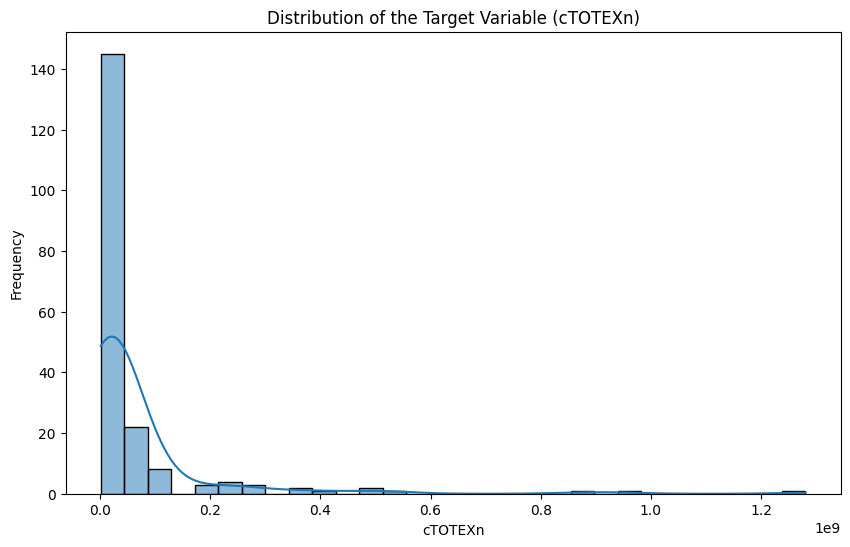

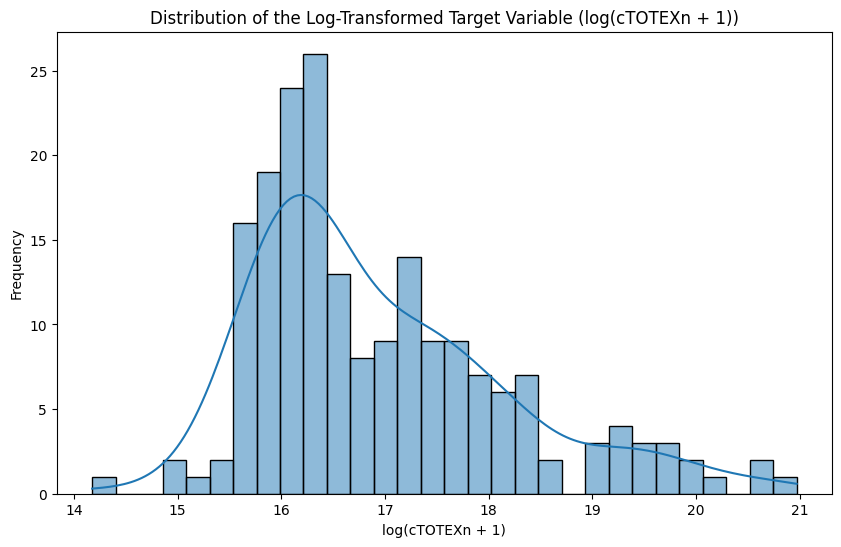

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['cTOTEXn'], kde=True, bins=30)
plt.title('Distribution of the Target Variable (cTOTEXn)')
plt.xlabel('cTOTEXn')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of the log-transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['cTOTEXn']), kde=True, bins=30)
plt.title('Distribution of the Log-Transformed Target Variable (log(cTOTEXn + 1))')
plt.xlabel('log(cTOTEXn + 1)')
plt.ylabel('Frequency')
plt.show()


Based on the plots, it is clear that the target variable cTOTEXn is highly skewed and benefits from a log transformation, as evidenced by the more normalized distribution of the log-transformed target variable.

In [15]:
# Log transform the target variable
df_train_imputed['cTOTEXn_log'] = np.log1p(df_train_imputed.pop('cTOTEXn'))
df_val_imputed['cTOTEXn_log'] = np.log1p(df_val_imputed.pop('cTOTEXn'))

# Save the datasets with the log-transformed target variable
train_set_with_log_target_path = "../data/trainingset_with_log_target.csv"
df_train_imputed.to_csv(train_set_with_log_target_path, index=False)
print(f"Training set with log-transformed target saved to {train_set_with_log_target_path}")

val_set_with_log_target_path = "../data/validationset_with_log_target.csv"
df_val_imputed.to_csv(val_set_with_log_target_path, index=False)
print(f"Validation set with log-transformed target saved to {val_set_with_log_target_path}")


Training set with log-transformed target saved to ../data/trainingset_with_log_target.csv
Validation set with log-transformed target saved to ../data/validationset_with_log_target.csv


C:\Users\Benedict\AppData\Local\Temp\ipykernel_39864\463074553.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_imputed['cTOTEXn_log'] = np.log1p(df_train_imputed.pop('cTOTEXn'))
C:\Users\Benedict\AppData\Local\Temp\ipykernel_39864\463074553.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val_imputed['cTOTEXn_log'] = np.log1p(df_val_imputed.pop('cTOTEXn'))
